# **License Plate Detection**

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import cv2
import glob
import numpy as np
import os
import shutil
from lxml import etree

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

**Import the Dataset**

Import the dataset from Kaggle and process it. Include move the data, process annotations, and split it.

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d imamdigmi/indonesian-plate-number

 98% 154M/157M [00:01<00:00, 79.7MB/s]
100% 157M/157M [00:01<00:00, 86.4MB/s]


In [4]:
! kaggle datasets download -d andrewmvd/car-plate-detection

 98% 200M/203M [00:02<00:00, 94.5MB/s]
100% 203M/203M [00:02<00:00, 93.8MB/s]


In [5]:
!unzip \*.zip

Archive:  indonesian-plate-number.zip
  inflating: plate_number_recognition_datasets_v1/annotations/test/351.E 6730 RC-07-19.xml  
  inflating: plate_number_recognition_datasets_v1/annotations/test/352.E 5053 RG-09-20.xml  
  inflating: plate_number_recognition_datasets_v1/annotations/test/353.E 6270 SM-06-20.xml  
  inflating: plate_number_recognition_datasets_v1/annotations/test/354.E 6250 PAJ-02-22.xml  
  inflating: plate_number_recognition_datasets_v1/annotations/test/355.E 6547 PAF-09-21.xml  
  inflating: plate_number_recognition_datasets_v1/annotations/test/356.E 6225 SJ-11-19.xml  
  inflating: plate_number_recognition_datasets_v1/annotations/test/357.E 4679 PAD-06-21.xml  
  inflating: plate_number_recognition_datasets_v1/annotations/test/358.E 3438 SJ-10-19.xml  
  inflating: plate_number_recognition_datasets_v1/annotations/test/359.E 6270 OZ-01-21.xml  
  inflating: plate_number_recognition_datasets_v1/annotations/test/360.E 4690 PAL-04-22.xml  
  inflating: plate_number_re

In [6]:
#variable
batch_size = 32
epochs = 50
image_shape = 224
img_size = (224, 224)

**Process Data**

In [7]:
# Define the directory
base_dir = 'plate_number_recognition_datasets_v1/images/train/'
annotations_dir = 'plate_number_recognition_datasets_v1/annotations/train/'

train_dir = 'images/'
annotations_train_dir = 'annotations/'
test_dir = 'plate_number_recognition_datasets_v1/images/test/'
annotations_test_dir = 'plate_number_recognition_datasets_v1/annotations/test/'

In [8]:
# File
train_file = os.listdir(train_dir)
annotations_train_file = os.listdir(annotations_train_dir)
test_file = os.listdir(test_dir)
annotations_test_file = os.listdir(annotations_test_dir)

# Move from test_dir to base_dir
for file_name in train_file:
    shutil.move(os.path.join(train_dir, file_name), base_dir)

# Move from annotations_test_dir to annotations_dir
for file_name in annotations_train_file:
    shutil.move(os.path.join(annotations_train_dir, file_name), annotations_dir)

# Move from test_dir to base_dir
for file_name in test_file:
    shutil.move(os.path.join(test_dir, file_name), base_dir)

# Move from annotations_test_dir to annotations_dir
for file_name in annotations_test_file:
    shutil.move(os.path.join(annotations_test_dir, file_name), annotations_dir)

In [9]:
# Process image in base_dir
base_path = os.path.join(base_dir,'*g')
base_files = glob.glob(base_path)
base_files.sort()
X=[]
for f1 in base_files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (img_size))
    X.append(np.array(img))

#resize annotations
def resize_annotations(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/image_shape)
        ymin = int(dim.xpath("ymin")[0].text)/(height/image_shape)
        xmax = int(dim.xpath("xmax")[0].text)/(width/image_shape)
        ymax = int(dim.xpath("ymax")[0].text)/(height/image_shape)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

# Append annotations
annotations = ['plate_number_recognition_datasets_v1/annotations/train/'+f for f in sorted(os.listdir(annotations_dir))]
y=[]
for annotations_file in annotations:
    y.append(resize_annotations(annotations_file))

In [10]:
resize_annotations("plate_number_recognition_datasets_v1/annotations/train/1.E 3977 QM-09-19.xml")

[223, 223, 0, 1]

In [11]:
print(y[0])
print(np.array(X).shape)
print(np.array(y).shape)

[223, 223, 0, 1]
(935, 224, 224, 3)
(935, 4)


In [12]:
# Transforming in array
X=np.array(X)
y=np.array(y)

In [13]:
# Renormalisation
X = X / 255
y = y / 255

In [14]:
# Split the Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)
print(len(X_train), len(X_val))

701 234


**The Model**

In [15]:
# Base model from VGG16
base_model = tf.keras.applications.VGG16(input_shape=img_size+(3,), include_top=False, weights="imagenet")

58892288/58889256 [==============================] - 0s 0us/step


In [16]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
# Fine Tuning
do_fine_tuning = False

In [18]:
feature_extractor = hub.KerasLayer(base_model,
                                   input_shape=img_size + (3,),
                                   trainable=do_fine_tuning)

In [19]:
# The Model
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(3, 5, activation='linear', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(2, 5, activation='softmax', padding='same'),
        tf.keras.layers.Conv2D(6, 3, activation='linear', padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 7, 7, 512)         14714688  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 3)           38403     
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 3)           12        
_________________________________________________________________
activation (Activation)      (None, 3, 3, 3)           0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 3)           0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 3)           0

In [20]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 15 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

**Train the Model**

In [21]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='mean_squared_error',
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

In [22]:
# Fits the model on batches
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    epochs=epochs)

Epoch 1/50
22/22 [==============================] - 49s 526ms/step - loss: 0.0815 - accuracy: 0.4779 - val_loss: 0.0638 - val_accuracy: 0.3974
Epoch 2/50
22/22 [==============================] - 3s 158ms/step - loss: 0.0496 - accuracy: 0.3652 - val_loss: 0.0364 - val_accuracy: 0.3974
Epoch 3/50
22/22 [==============================] - 3s 158ms/step - loss: 0.0335 - accuracy: 0.4964 - val_loss: 0.0324 - val_accuracy: 0.6026
Epoch 4/50
22/22 [==============================] - 3s 158ms/step - loss: 0.0274 - accuracy: 0.6591 - val_loss: 0.0228 - val_accuracy: 0.6752
Epoch 5/50
22/22 [==============================] - 3s 159ms/step - loss: 0.0182 - accuracy: 0.6548 - val_loss: 0.0151 - val_accuracy: 0.6752
Epoch 6/50
22/22 [==============================] - 3s 159ms/step - loss: 0.0140 - accuracy: 0.6633 - val_loss: 0.0138 - val_accuracy: 0.6667
Epoch 7/50
22/22 [==============================] - 3s 160ms/step - loss: 0.0132 - accuracy: 0.6605 - val_loss: 0.0133 - val_accuracy: 0.6538
Epoch

**Detection**

<Figure size 432x288 with 0 Axes>

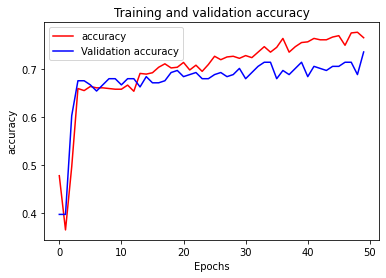

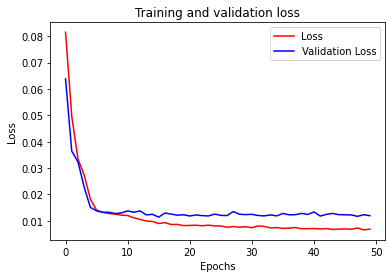

<Figure size 432x288 with 0 Axes>

In [23]:
# Plot training and validation loss per epoch
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(accuracy)) 

plt.plot(epochs, accuracy, 'r')
plt.plot(epochs, val_accuracy, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["accuracy", "Validation accuracy"])

plt.figure()


plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

# **Save Model**

In [24]:
model.save_weights('my_model_weights.h5')